**Recommender System using Pyspark**

In [ ]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [29.3 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,866 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,072 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,536 kB]
Get:13 https://developer.download.nvidi

In [ ]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
!ls

book_ratings.csv  spark-3.2.1-bin-hadoop3.2
sample_data	  spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
import findspark
findspark.init()

In [ ]:
# Check the location for Spark
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
#importing the required pyspark library
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

#Setup Spark Session
spark = SparkSession.builder.appName('Recommender').getOrCreate()
spark


In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load your DataFrame from a source
df = spark.read.csv("/content/book_ratings.csv", header=True, inferSchema=True)

# Count the number of rows using map-reduce
num_rows = df.rdd.map(lambda row: 1).reduce(lambda a, b: a + b)

# Get the column names
column_names = df.columns

# Count the number of columns
num_columns = len(column_names)

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 981756
Number of columns: 3


In [ ]:
# Count the total number of ratings
total_ratings = df.rdd.map(lambda row: 1).reduce(lambda a, b: a + b)

# Calculate the average rating
total_sum = df.rdd.map(lambda row: row['rating']).reduce(lambda a, b: a + b)
average_rating = total_sum / total_ratings

# Find the maximum and minimum ratings
max_rating = df.rdd.map(lambda row: row['rating']).reduce(lambda a, b: max(a, b))
min_rating = df.rdd.map(lambda row: row['rating']).reduce(lambda a, b: min(a, b))

# Print the results
print("Total number of ratings:", total_ratings)
print("Average rating:", average_rating)
print("Maximum rating:", max_rating)
print("Minimum rating:", min_rating)

df.show(5)


Total number of ratings: 981756
Average rating: 3.8565335989797873
Maximum rating: 5
Minimum rating: 1
+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


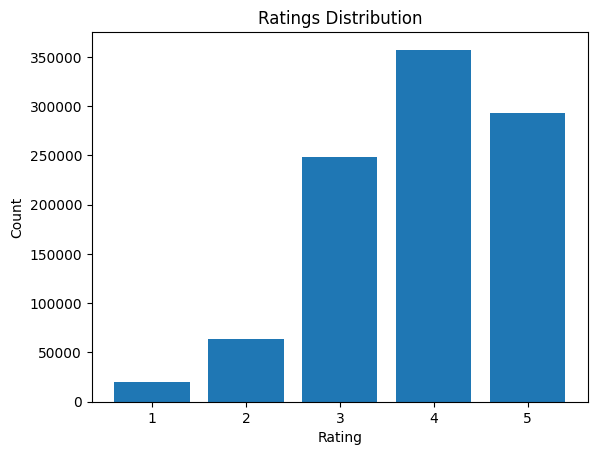

In [ ]:
# Count the frequency of each rating
rating_counts = df.rdd.map(lambda row: (row['rating'], 1)).reduceByKey(lambda a, b: a + b).collect()

# Extract the rating values and their corresponding counts
ratings = [rating[0] for rating in rating_counts]
counts = [rating[1] for rating in rating_counts]

# Visualize the ratings distribution
plt.bar(ratings, counts)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Distribution')
plt.show()

In [ ]:
# Map each user ID to a count of purchases
user_purchases = df.rdd.map(lambda row: (row['user_id'], 1)).reduceByKey(lambda a, b: a + b)

# Find the user with the maximum purchases
most_purchased_user = user_purchases.max(lambda x: x[1])

# Print the result
print("User with the most purchases:", most_purchased_user[0])
print("Number of purchases:", most_purchased_user[1])

User with the most purchases: 12874
Number of purchases: 200


In [ ]:
# Map each product ID to a count of purchases
product_purchases = df.rdd.map(lambda row: (row['book_id'], 1)).reduceByKey(lambda a, b: a + b)

# Find the product with the maximum purchases
most_purchased_product = product_purchases.max(lambda x: x[1])

# Print the result
print("Most purchased product:", most_purchased_product[0])
print("Number of purchases:", most_purchased_product[1])

Most purchased product: 2
Number of purchases: 100


In [ ]:
# Map each product ID to its average rating
product_ratings = df.rdd.map(lambda row: (row['book_id'], (row['rating'], 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda x: x[0] / x[1])

# Sort the products by average rating in descending order
sorted_products = product_ratings.sortBy(lambda x: x[1], ascending=False)

# Get the top 5 products
top_5_products = sorted_products.take(5)

# Print the result
print("Top 5 products with the highest ratings:")
for product in top_5_products:
    print("Product:", product[0])
    print("Average Rating:", product[1])
    print()

Top 5 products with the highest ratings:
Product: 7947
Average Rating: 4.820224719101123

Product: 6920
Average Rating: 4.78

Product: 5207
Average Rating: 4.78

Product: 9566
Average Rating: 4.777777777777778

Product: 8946
Average Rating: 4.774193548387097



In [ ]:
# Map each product ID to a count of purchases
product_purchases = df.rdd.map(lambda row: (row['book_id'], 1)).reduceByKey(lambda a, b: a + b)

# Sort the products by purchase count in descending order
sorted_products = product_purchases.sortBy(lambda x: x[1], ascending=False)

# Get the top 5 products
top_5_products = sorted_products.take(5)

# Print the result
print("Top 5 products with the most purchases:")
for product in top_5_products:
    print("Product:", product[0])
    print("Number of Purchases:", product[1])
    print()




Top 5 products with the most purchases:
Product: 2
Number of Purchases: 100

Product: 4
Number of Purchases: 100

Product: 6
Number of Purchases: 100

Product: 8
Number of Purchases: 100

Product: 10
Number of Purchases: 100



In [ ]:
# Map each customer ID to a count of purchases
customer_purchases = df.rdd.map(lambda row: (row['user_id'], 1)).reduceByKey(lambda a, b: a + b)

# Sort the customers by purchase count in descending order
sorted_customers = customer_purchases.sortBy(lambda x: x[1], ascending=False)

# Get the top 5 customers
top_5_customers = sorted_customers.take(5)

# Print the result
print("Top 5 customers with the highest number of purchases:")
for customer in top_5_customers:
    print("Customer:", customer[0])
    print("Number of Purchases:", customer[1])
    print()

Top 5 customers with the highest number of purchases:
Customer: 12874
Number of Purchases: 200

Customer: 30944
Number of Purchases: 200

Customer: 28158
Number of Purchases: 199

Customer: 52036
Number of Purchases: 199

Customer: 12381
Number of Purchases: 199



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

In [ ]:
# Check for null values in the DataFrame
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Display the null value counts
null_counts.show()

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+

